<a href="https://colab.research.google.com/github/dah4ik/GenAI-Project/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. SETUP AND LIBRARIES
# ==========================================================
!pip install -q ultralytics roboflow

import os
import cv2
import yaml
import shutil
from google.colab import drive
from ultralytics import YOLO
from roboflow import Roboflow

drive.mount('/content/drive')

# Paths based on your screenshots
BASE_DIR = '/content/drive/MyDrive/genai/DataSet2/Images (1)'
SYNTHETIC_DIR = '/content/drive/MyDrive/genai/DataSet2/synthetic_data'
RAW_IMAGES_DIR = os.path.join(BASE_DIR, 'raw_images')
FINAL_DATASET_DIR = os.path.join(BASE_DIR, 'final_combined_dataset')

# Create target directories
os.makedirs(RAW_IMAGES_DIR, exist_ok=True)
for split in ['train', 'val']:
    os.makedirs(os.path.join(FINAL_DATASET_DIR, split, 'images'), exist_ok=True)
    os.makedirs(os.path.join(FINAL_DATASET_DIR, split, 'labels'), exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 2. MODELS INITIALIZATION (For Auto-Annotation)
# ==========================================================
RF_API_KEY = "AN5yeFVSiC6FPxaNIVOT"
rf = Roboflow(api_key=RF_API_KEY)

def get_latest_model(workspace_id, project_id):
    """Automatically fetches the latest version of the specified Roboflow project"""
    project = rf.workspace(workspace_id).project(project_id)
    latest_v = project.versions()[0].version_number
    print(f"Loaded: {project_id} v{latest_v}")
    return project.version(latest_v).model

# Base YOLOv8 model for standard objects (Knives=43, Scissors=76, Bottles=39)
base_model = YOLO('yolov8s.pt')

# Custom models from Roboflow Universe
battery_model = rf.workspace("battery-detector").project("battery-x0y91").version(2).model
lego_model    = rf.workspace("concours-objets-intelligents").project("lego-aprqg").version(2).model
coin_model    = rf.workspace("rohith-xznmb").project("coins-lknzw").version(1).model
power_model   = rf.workspace("cjbs").project("cattle-upi-power").version(2).model
plastic_model = rf.workspace("snowman1908").project("plastic-recyclable-detection").version(1).model

loading Roboflow workspace...
loading Roboflow project...
loading Roboflow workspace...
loading Roboflow project...
loading Roboflow workspace...
loading Roboflow project...
loading Roboflow workspace...
loading Roboflow project...
loading Roboflow workspace...
loading Roboflow project...


In [ ]:
# 3. MAPPING AND UTILS
# ==========================================================
MY_CLASSES = {
    'sharp_object': 0,
    'choking_hazard': 1,
    'electrical_hazard': 2,
    'chemical_danger': 3
}

def get_yolo_coords(pred, img_w, img_h):
    """Convert Roboflow dictionary prediction to YOLO string format"""
    xc = pred['x'] / img_w
    yc = pred['y'] / img_h
    nw = pred['width'] / img_w
    nh = pred['height'] / img_h
    return f"{xc:.6f} {yc:.6f} {nw:.6f} {nh:.6f}"

In [ ]:
# 4. STAGE 1: AUTO-ANNOTATE SYNTHETIC DATA
# ==========================================================
print("STAGE 1: Annotating synthetic data with Fallback...")

for class_name, class_id in MY_CLASSES.items():
    synth_path = os.path.join(SYNTHETIC_DIR, class_name, 'images')
    if not os.path.exists(synth_path): continue

    files = [f for f in os.listdir(synth_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    print(f"  Processing {class_name}...")

    for filename in files:
        img_path = os.path.join(synth_path, filename)
        image = cv2.imread(img_path)
        if image is None: continue
        h, w, _ = image.shape
        labels = []

        # AI Detection attempt
        if class_name == 'sharp_object':
            res = base_model(image)[0]
            for box in res.boxes:
                if int(box.cls) in [43, 76]:
                    xywh = box.xywhn[0].tolist()
                    labels.append(f"{class_id} {xywh[0]:.6f} {xywh[1]:.6f} {xywh[2]:.6f} {xywh[3]:.6f}")

        elif class_name == 'choking_hazard':
            for m in [battery_model, lego_model, coin_model]:
                preds = m.predict(img_path, confidence=30).json()['predictions']
                for p in preds: labels.append(f"{class_id} {get_yolo_coords(p, w, h)}")

        elif class_name == 'electrical_hazard':
            preds = power_model.predict(img_path, confidence=30).json()['predictions']
            for p in preds: labels.append(f"{class_id} {get_yolo_coords(p, w, h)}")

        elif class_name == 'chemical_danger':
            res = base_model(image)[0]
            for box in res.boxes:
                if int(box.cls) == 39:
                    xywh = box.xywhn[0].tolist()
                    labels.append(f"{class_id} {xywh[0]:.6f} {xywh[1]:.6f} {xywh[2]:.6f} {xywh[3]:.6f}")

        # --- FALLBACK: If AI found nothing in a dedicated folder, mark center ---
        if not labels:
            # 0.5 0.5 is center, 0.8 0.8 is 80% width/height
            labels.append(f"{class_id} 0.500000 0.500000 0.800000 0.800000")

        # Save to the FINAL dataset folder
        final_name = f"synth_{class_name}_{os.path.splitext(filename)[0]}"
        with open(os.path.join(FINAL_DATASET_DIR, 'train', 'labels', f"{final_name}.txt"), 'w') as f:
            f.write("\n".join(labels))
        cv2.imwrite(os.path.join(FINAL_DATASET_DIR, 'train', 'images', f"{final_name}.jpg"), image)

print("Stage 1 update complete.")

STAGE 1: Annotating synthetic data with Fallback...
  Processing sharp_object...

0: 640x640 2 knifes, 16.5ms
Speed: 7.8ms preprocess, 16.5ms inference, 43.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 knifes, 17.0ms
Speed: 8.0ms preprocess, 17.0ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 knife, 17.0ms
Speed: 7.4ms preprocess, 17.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 knife, 1 vase, 16.5ms
Speed: 5.6ms preprocess, 16.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 knife, 1 scissors, 16.6ms
Speed: 5.0ms preprocess, 16.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 knife, 16.5ms
Speed: 3.8ms preprocess, 16.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 knife, 1 scissors, 16.5ms
Speed: 4.1ms preprocess, 16.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x6

In [ ]:
# 5. STAGE 2: AUTO-ANNOTATE RAW PHOTOS
# ==========================================================
print("STAGE 2: Auto-annotating raw photos from RAW_IMAGES_DIR...")
raw_files = [f for f in os.listdir(RAW_IMAGES_DIR) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
image_counter = 0

for filename in raw_files:
    img_path = os.path.join(RAW_IMAGES_DIR, filename)
    image = cv2.imread(img_path)
    if image is None: continue
    h, w, _ = image.shape
    labels = []

    # YOLO Base (Knives/Scissors/Bottles)
    results = base_model(image)[0]
    for box in results.boxes:
        cid, xywh = int(box.cls), box.xywhn[0].tolist()
        coords = f"{xywh[0]:.6f} {xywh[1]:.6f} {xywh[2]:.6f} {xywh[3]:.6f}"
        if cid in [43, 76]: labels.append(f"{MY_CLASSES['sharp_object']} {coords}")
        elif cid == 39: labels.append(f"{MY_CLASSES['chemical_danger']} {coords}")

    # Roboflow Models (Batteries, Lego, Coins) -> Choking
    for m in [battery_model, lego_model, coin_model]:
        try:
            preds = m.predict(img_path, confidence=40).json()
            for p in preds['predictions']:
                labels.append(f"{MY_CLASSES['choking_hazard']} {get_yolo_coords(p, w, h)}")
        except Exception as e:
            print(f"      Warning: Failed to predict with {m} for {filename}: {e}")

    # Electrical Outlets -> Electrical Hazard
    try:
        e_preds = power_model.predict(img_path, confidence=40).json()
        for p in e_preds['predictions']:
            labels.append(f"{MY_CLASSES['electrical_hazard']} {get_yolo_coords(p, w, h)}")
    except Exception as e:
            print(f"      Warning: Failed to predict with power_model for {filename}: {e}")

    # Save results
    if labels: # Only save if detections were made
        with open(os.path.join(FINAL_DATASET_DIR, 'train', 'labels', filename.replace('.jpg', '.txt').replace('.png', '.txt')), 'w') as f:
            f.write("\n".join(labels))
        shutil.copy(img_path, os.path.join(FINAL_DATASET_DIR, 'train', 'images', filename))
        image_counter += 1
    else:
        print(f"      No detections made for raw image: {filename}. Skipping.")

print(f"STAGE 2 Complete. {image_counter} raw images annotated and added to dataset.")

STAGE 2: Auto-annotating raw photos from RAW_IMAGES_DIR...

0: 640x640 1 cup, 2 chairs, 1 couch, 1 potted plant, 1 dining table, 7 teddy bears, 20.8ms
Speed: 8.9ms preprocess, 20.8ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 640)
      No detections made for raw image: 09de36b92e2946f38f4128f6f0b889b6.png. Skipping.

0: 640x640 1 bed, 6 teddy bears, 16.5ms
Speed: 4.0ms preprocess, 16.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 bottles, 2 chairs, 2 potted plants, 1 teddy bear, 16.6ms
Speed: 4.8ms preprocess, 16.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 potted plant, 2 beds, 1 teddy bear, 16.4ms
Speed: 4.5ms preprocess, 16.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 bowl, 1 chair, 1 potted plant, 1 bed, 16.5ms
Speed: 4.2ms preprocess, 16.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
      No detections made for raw image: 857ce564

In [ ]:
# 6. TRAINING
# ==========================================================
print("STAGE 3: Starting training...")
config = {
    'path': FINAL_DATASET_DIR,
    'train': 'train/images',
    'val': 'train/images',
    'names': {i: name for name, i in MY_CLASSES.items()}
}
with open(os.path.join(BASE_DIR, 'final_data.yaml'), 'w') as f:
    yaml.dump(config, f)

model = YOLO('yolov8n.pt')
model.train(data=os.path.join(BASE_DIR, 'final_data.yaml'), epochs=100, imgsz=640, name='safety_model_v3')

print("All stages complete. Model training finished.")

STAGE 3: Starting training...
Ultralytics 8.4.7 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/genai/DataSet2/Images (1)/final_data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=safety_model_v3, nbs=64, nms=False, opset=None, optimize=False, 

In [ ]:
import shutil
import os
import glob
from google.colab import drive

# 1. Connect Google Disc
drive.mount('/content/drive')

# 2. NASTRAIVAEM PUTI
# Save Backup
DESTINATION_ROOT = '/content/drive/MyDrive/genai/DataSet2'


runs_path = '/content/runs/detect'
all_runs = glob.glob(os.path.join(runs_path, '*/'))

if all_runs:

    latest_run_path = max(all_runs, key=os.path.getmtime)
    run_name = os.path.basename(os.path.normpath(latest_run_path))


    final_destination = os.path.join(DESTINATION_ROOT, run_name)


    if os.path.exists(final_destination):
        print(f"⚠️ Папка {run_name} уже существует на Диске. Удаляю старую версию...")
        shutil.rmtree(final_destination)

    print(f"📂 Копирую папку {run_name} на Google Диск...")
    shutil.copytree(latest_run_path, final_destination)


    yaml_src = '/content/drive/MyDrive/genai/DataSet2/final_data.yaml'
    if os.path.exists(yaml_src):
        shutil.copy(yaml_src, os.path.join(final_destination, 'config_used.yaml'))

    print(f"✅ Done: {final_destination}")
else:
    print("❌ Папки с результатами не найдены.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📂 Копирую папку safety_model_v3 на Google Диск...
✅ Done: /content/drive/MyDrive/genai/DataSet2/safety_model_v3


Using results from: /content/runs/detect/safety_model_v3/

--- confusion_matrix.png ---


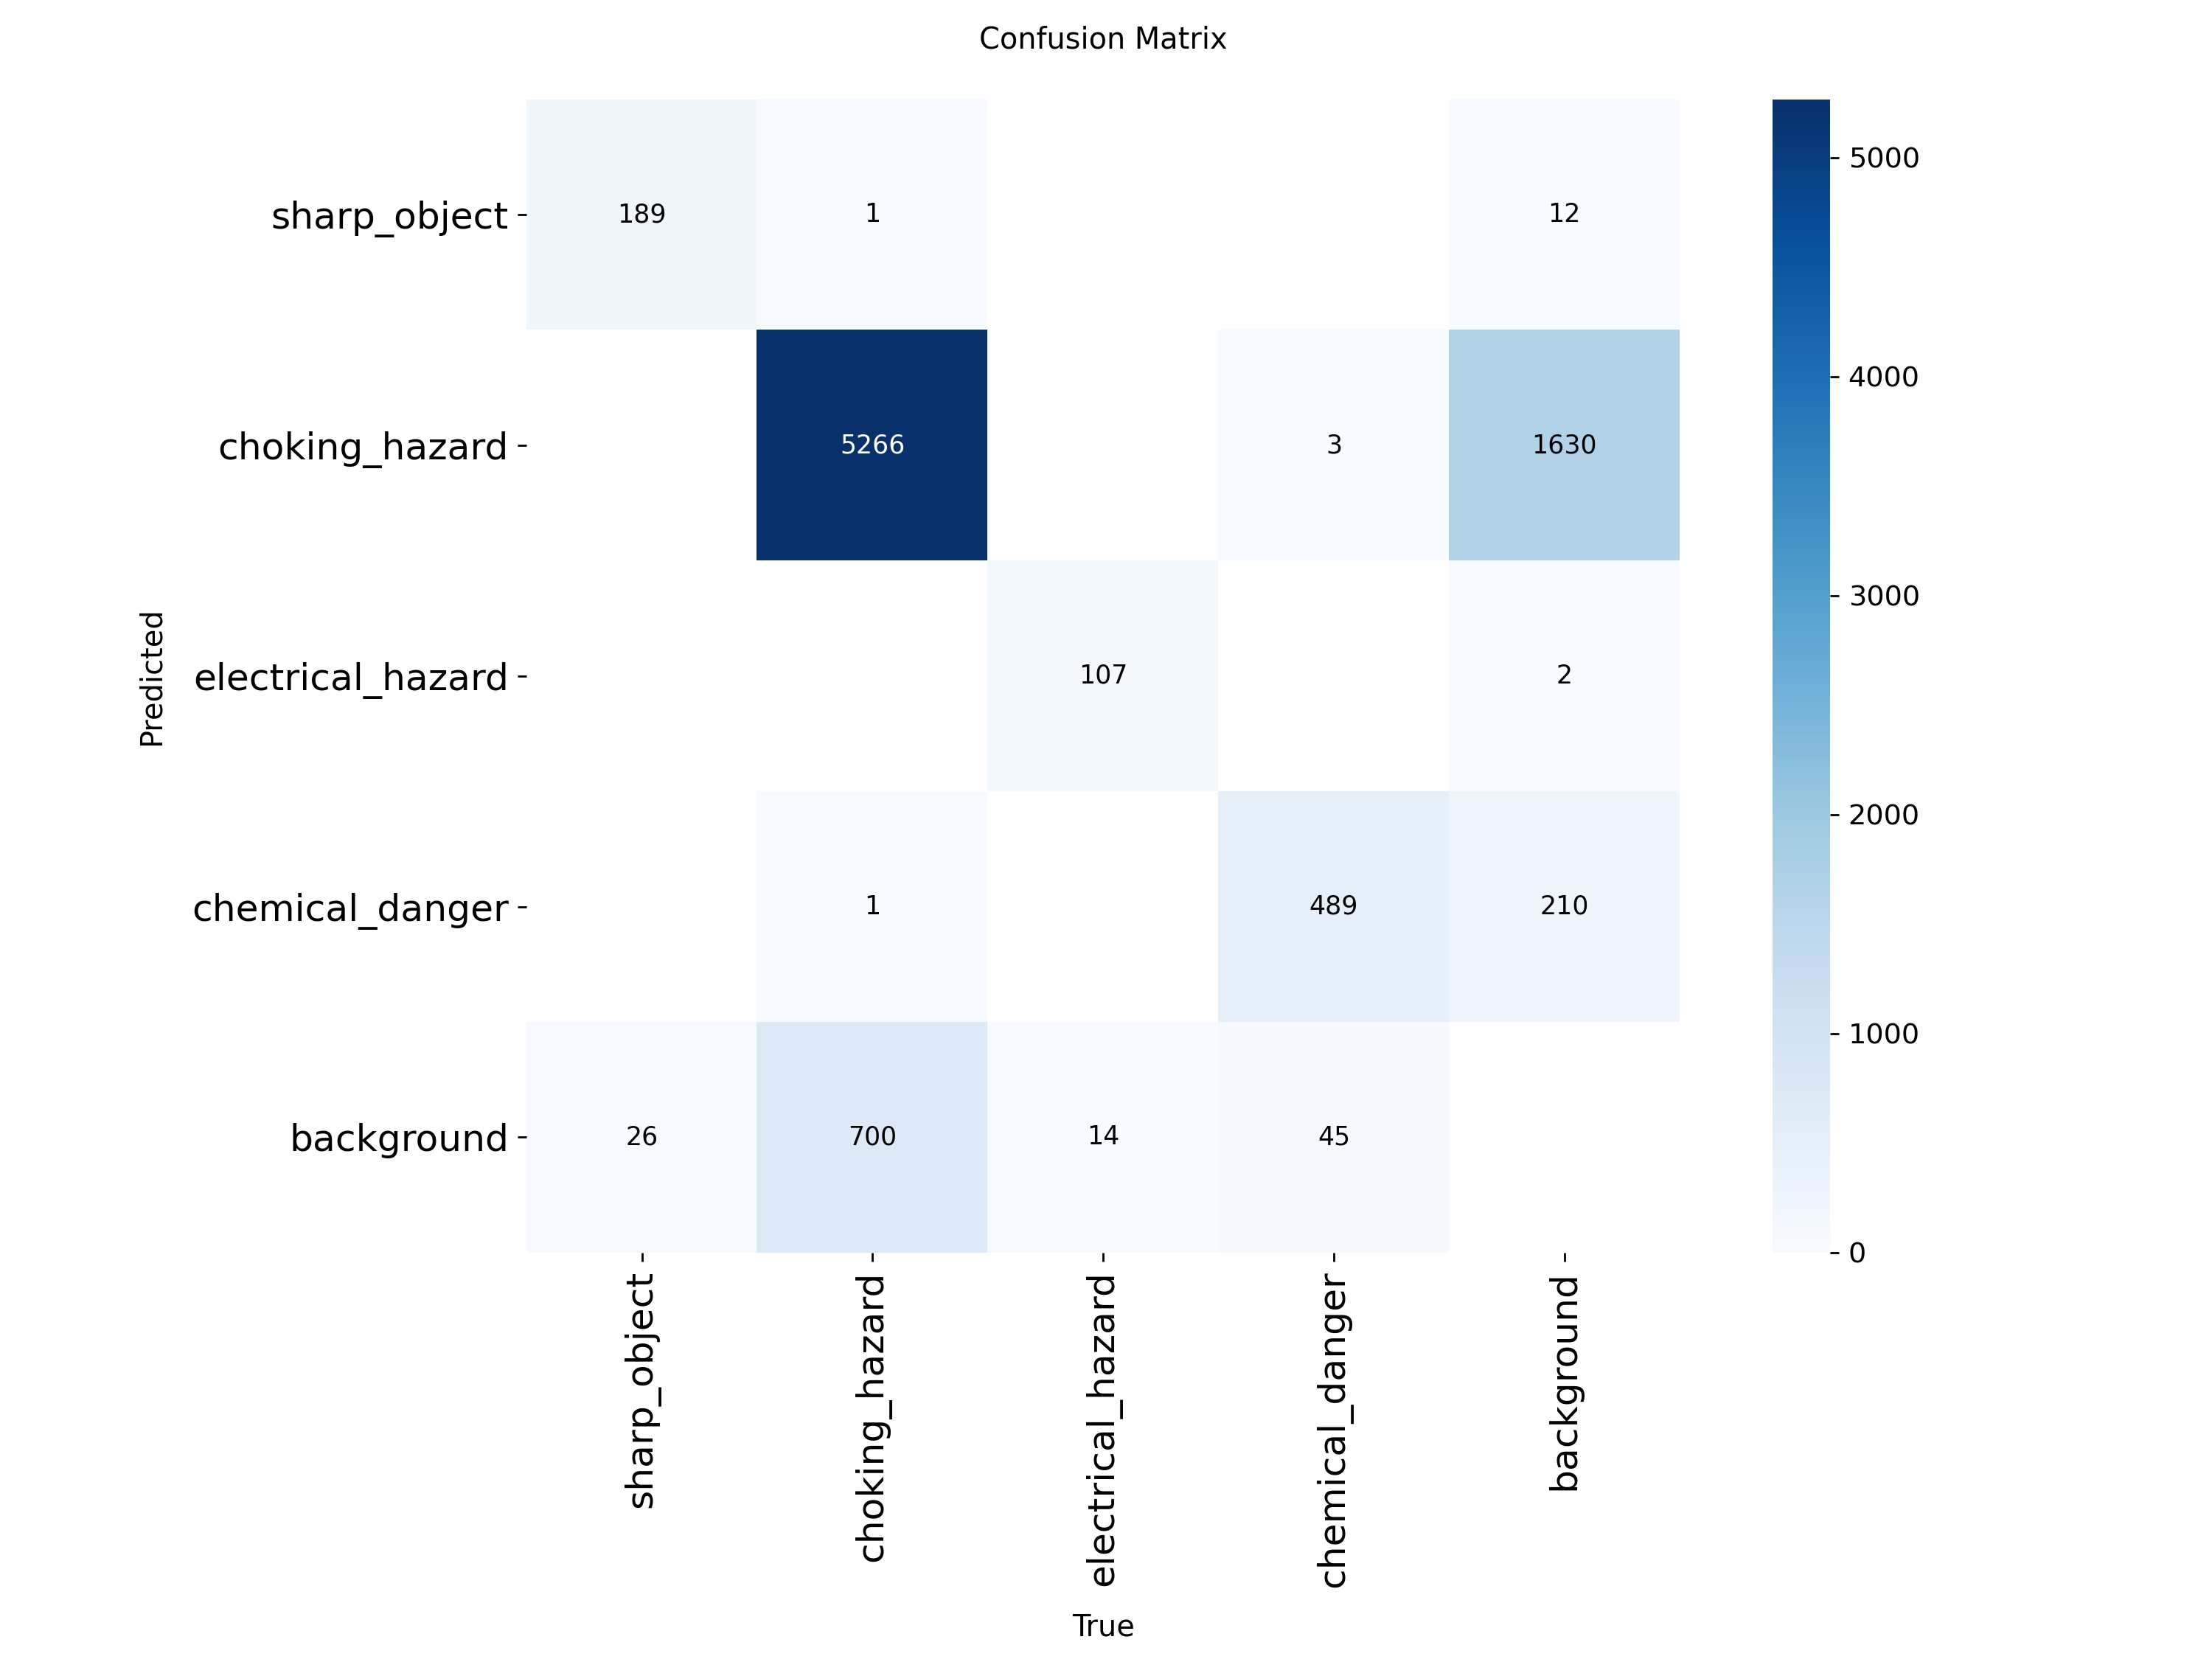


--- results.png ---


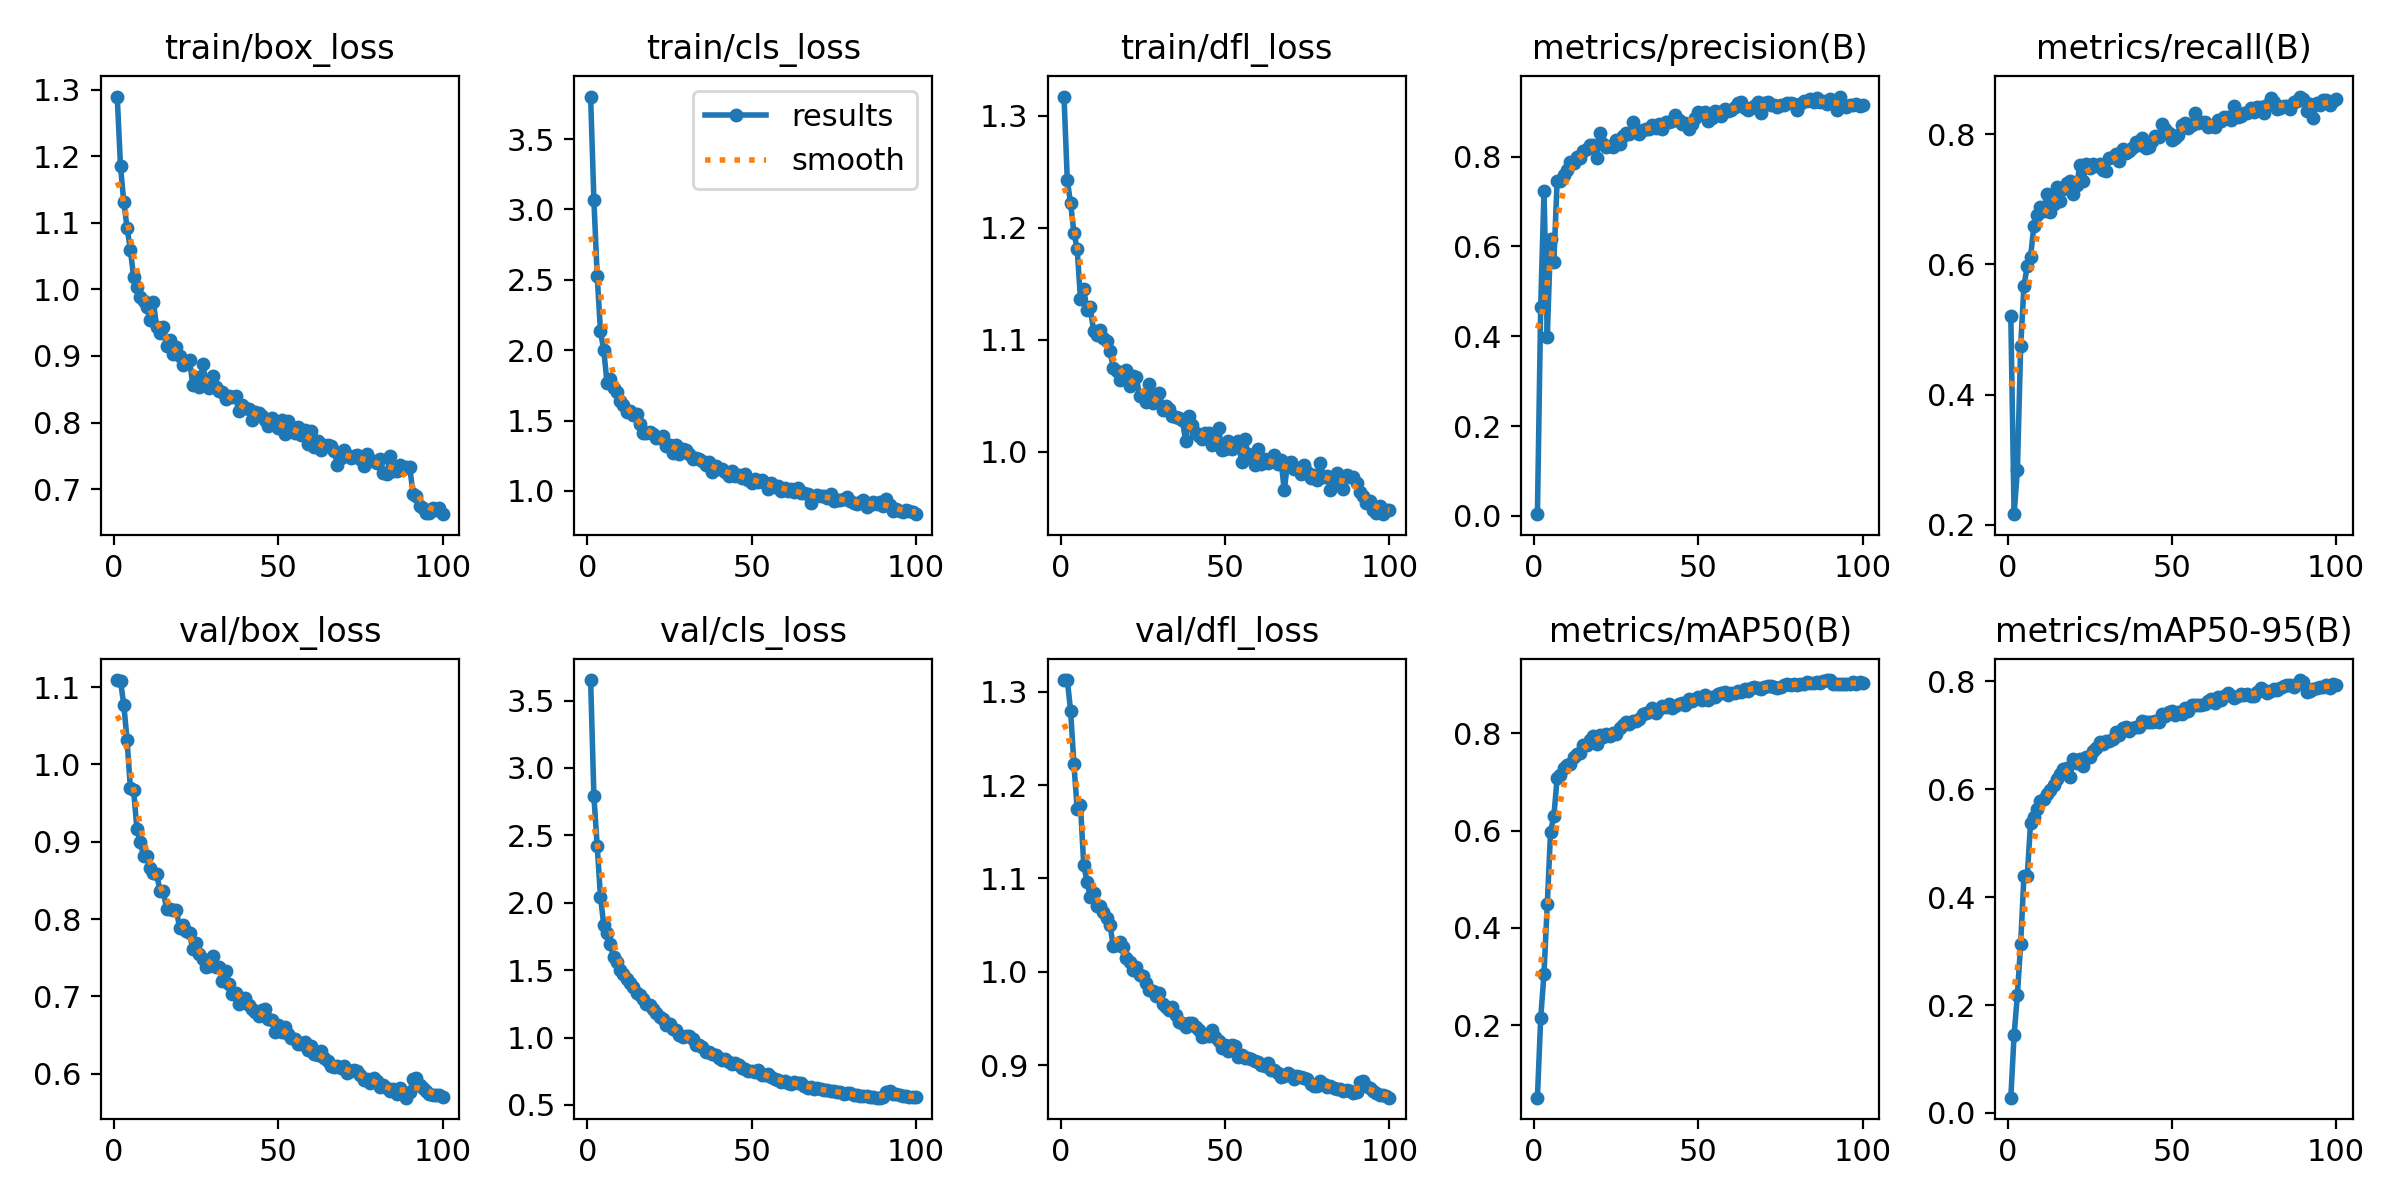

File F1_curve.png not found in this run.
File PR_curve.png not found in this run.


In [ ]:
import os
import glob
from IPython.display import Image, display

# 1. Automatically find the latest training directory
runs_path = '/content/runs/detect'
all_runs = glob.glob(os.path.join(runs_path, '*/'))
if all_runs:
    # Sort by creation time to get the newest folder
    latest_run = max(all_runs, key=os.path.getmtime)
    print(f"Using results from: {latest_run}")

    # List of files we want to display
    metrics_to_show = [
        'confusion_matrix_normalized.png',
        'results.png',
        'F1_curve.png',
        'PR_curve.png'
    ]

    for metric in metrics_to_show:
        img_path = os.path.join(latest_run, metric)
        if os.path.exists(img_path):
            print(f"\n--- {metric} ---")
            display(Image(filename=img_path, width=800))
        else:
            print(f"File {metric} not found in this run.")
else:
    print("No training runs found in /content/runs/detect. Check if training finished successfully.")